# Digit Recognition with Inception Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import keras
from keras import backend as K
from keras import layers
from keras import optimizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", None)

keras_version = keras.__version__
tf_version = K.tensorflow_backend.tf.VERSION

print("keras version:", keras_version)
print(K.backend(), "version:", tf_version)

Using TensorFlow backend.


keras version: 2.2.2
tensorflow version: 1.10.0


### Data Prep

In [2]:
# load data
rawdata = np.loadtxt('train.csv', dtype=int, delimiter=',', skiprows=1)

In [3]:
# inspect data
print("Raw data shape:", rawdata.shape)

# split labels and pixel values
y = rawdata[:, 0]
X = rawdata[:, 1:]
print("Labels shape:", y.shape)
print("Pixels shape:", X.shape)

# convert pixel values to 2d arrays
X = np.reshape(X, (42000, 28, 28))
print("Pixels reshaped shape:", X.shape)

Raw data shape: (42000, 785)
Labels shape: (42000,)
Pixels shape: (42000, 784)
Pixels reshaped shape: (42000, 28, 28)


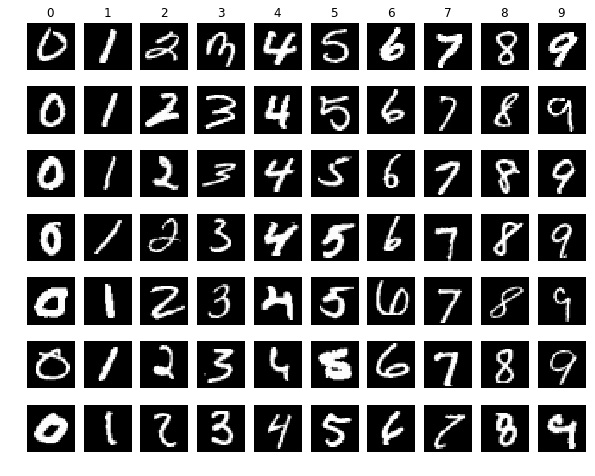

In [4]:
# display random sample of images
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

num_classes = 10
samples_per_class = 7
for cls in range(num_classes):
    idxs = np.flatnonzero(y == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# prep the data for training

# one hot encode labels
y_oh = to_categorical(y, num_classes)

# convert pixel values to be between -1 and 1
X_norm = X / 127.5 - 1
X_norm = np.expand_dims(X_norm, -1)

# split data into train and validation sets
num_val = int(y.shape[0] * 0.1)
validation_mask = np.zeros(y.shape[0], np.bool)
np.random.seed(1)
for c in range(num_classes):
    idxs = np.random.choice(np.flatnonzero(y == c), num_val // 10, replace=False)
    validation_mask[idxs] = 1
np.random.seed(None)  
    
X_train = X_norm[~validation_mask]
X_val = X_norm[validation_mask]
print(X_train.shape, X_val.shape)

y_train = y_oh[~validation_mask]
y_val = y_oh[validation_mask]
print(y_train.shape, y_val.shape)

# confirm validation set is balanced across classes
print(np.bincount(y[validation_mask]))

(37800, 28, 28, 1) (4200, 28, 28, 1)
(37800, 10) (4200, 10)
[420 420 420 420 420 420 420 420 420 420]


### Useful Classes / Functions

In [6]:
class ThresholdModelCheckpoint(keras.callbacks.Callback):
    """Save the model when the monitored quantity passes `threshold` .
    
    This is a modified version of ModelCheckpoint from Keras.
    
    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and 
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        filepath: string, path to save the model file.
        threshold: save model file if `the quantity monitored 
            passes `threshold`, and the model is the latest best 
            model according to the quantity monitored.        
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, filepath, threshold, monitor='val_acc', 
                 verbose=0, save_weights_only=False,
                 mode='auto', period=1):
        super(ThresholdModelCheckpoint, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.verbose = verbose
        self.filepath = filepath
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can save model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best) and self.monitor_op(current, self.threshold):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved to %0.5f,'
                              ' saving model to %s'
                              % (epoch + 1, self.monitor, current, filepath))
                    self.best = current
                    if self.save_weights_only:
                        self.model.save_weights(filepath, overwrite=True)
                    else:
                        self.model.save(filepath, overwrite=True)
                   

class LinearDecay(keras.callbacks.Callback):
    '''
    Rate of change = (lr0 - end_lr) / M
    '''
    def __init__(self, M, end_lr=0, min_lr=0.0001):
        self.i = 1
        self.M = M
        self.lr0 = None
        self.end_lr = end_lr
        self.min_lr = min_lr
        
    def on_train_begin(self, logs=None):    
        lr = K.get_value(self.model.optimizer.lr)                                 
        if self.lr0 is None:
            self.lr0 = lr
        else:
            print('Learning rate is %s.' % (lr))
        
    def on_batch_end(self, batch, logs=None):
        lr = self.lr0 - (self.lr0 - self.end_lr) * self.i / self.M  
        self.i += 1
        if lr > self.min_lr:
            K.set_value(self.model.optimizer.lr, lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
        
def plot_training_log(log, acc=True, loss=True, lr=True, figsize=(10.0, 2.5)):
    plt.rcParams['figure.figsize'] = figsize
    i = log['val_acc'].idxmax() + 1
    
    if acc:
        plt.axvline(x=i, color='0.5', linestyle='--')
        plt.plot(log['epoch'], log['acc'], label='Train')
        plt.plot(log['epoch'], log['val_acc'], label='Validation')
        plt.minorticks_on()
        plt.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xlim(0, log['epoch'].iloc[-1] + 1)
        #plt.ylim(0.9, 1.0)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    if loss:
        plt.axvline(x=i, color='0.5', linestyle='--')
        plt.plot(log['epoch'], log['loss'], label='Train')
        plt.plot(log['epoch'], log['val_loss'], label='Validation')
        plt.minorticks_on()
        plt.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xlim(0, log['epoch'].iloc[-1] + 1)
        #plt.ylim(0.9, 1.0)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    if lr and 'lr' in log.columns:
        fig, ax1 = plt.subplots()
        plt.axvline(x=i, color='0.5', linestyle='--')

        ln1 = ax1.plot(log['epoch'], log['lr'], 'C4o-', label='Learning Rate')   
        ax1.set_xticks(log['epoch'], minor=True)
        ax1.grid(b=True, axis='x', which='both', color='0.8', linestyle='-')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Learning Rate')
        ax1.set_xlim(0, log['epoch'].iloc[-1] + 1)

        ax2 = ax1.twinx()
        ln2 = ax2.plot(log['epoch'], log['val_acc'], 'C1o-', 
                       label='Validation Accuracy [0.98 - 1.0]')        
        #ax2.set_ylabel('Val Accuracy')
        ax2.set_yticks([])
        ax2.set_ylim(0.98, 1.0)        

        lns = ln1 + ln2
        plt.legend(lns, [l.get_label() for l in lns])
        plt.tight_layout()
        plt.show()
        
        
def evaluate_model(model, X, y, log=None, pre_train_weights=None):
    scores = model.predict(X)
    predictions = np.argmax(scores, axis=1)
    y_digits = np.nonzero(y)[1]
       
    print("Accuracy:",  np.mean(predictions == y_digits))

    if log is not None:
        plot_training_log(log)

    post_train_weights = model.get_layer('conv_1').get_weights()[0]
    post_train_weights = post_train_weights.transpose(3, 2, 0, 1)
    num_weights = len(post_train_weights)
    if pre_train_weights is not None:
        plt.rcParams['figure.figsize'] = (10.0, 3.0)
        for i in range(num_weights):
            plt.subplot(4, num_weights // 4, i + 1)
            ker = pre_train_weights[i, 0]
            low, high = np.amin(ker), np.max(ker)
            plt.imshow(255 * (ker - low) / (high - low))
            plt.axis('off')
        plt.suptitle('Pre-Training Weights from First Convolutional Layer')
        plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 3.0)
    for i in range(num_weights):
        plt.subplot(4, num_weights // 4, i + 1)
        ker = post_train_weights[i, 0]
        low, high = np.amin(ker), np.max(ker)
        plt.imshow(255 * (ker - low) / (high - low))
        plt.axis('off')
    plt.suptitle('Post-Training Weights from First Convolutional Layer')
    plt.show()

    misclassified_mask = (predictions != y_digits)
    samples_per_class = 7
    num_classes = 10
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    for cls in range(10):
        idxs = np.flatnonzero(y_digits[misclassified_mask] == cls)
        if len(idxs) > samples_per_class:
            idxs = np.random.choice(idxs, samples_per_class, replace=False)       
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + cls + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X[misclassified_mask][idx,:,:,0])
            plt.axis('off')
            plt.text(14, 27, 'Pred:' + str(predictions[misclassified_mask][idx]), 
                     horizontalalignment='center', verticalalignment='top')        
            if i == 0:
                plt.title(cls)            
    plt.suptitle('Misclassified')
    plt.show()

### Inception Modules

In [7]:
def conv2D(x, filters, kernel_size, strides, padding='valid', kernel_initializer='glorot_uniform', batch_norm=True):
    if batch_norm:
        x = layers.Conv2D(filters=filters, 
                          kernel_size=kernel_size, 
                          strides=strides, 
                          padding=padding, 
                          kernel_initializer=kernel_initializer, 
                          use_bias=False)(x)
        x = layers.BatchNormalization(scale=False)(x)
    else:
        x = layers.Conv2D(filters=filters, 
                          kernel_size=kernel_size, 
                          strides=strides, 
                          padding=padding, 
                          kernel_initializer=kernel_initializer, 
                          use_bias=True)(x)

    return layers.Activation('relu')(x)
    #return layers.PReLU(alpha_initializer=keras.initializers.Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x)


def inception_module_A(x, filters=None, dropout=None, kernel_initializer='glorot_uniform', batch_norm=True):
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 4
        
    b1 = conv2D(x, 
                filters=(branch_filters // 3) * 2, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b1 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 3) * 2))(b1)
        b1 = layers.SpatialDropout2D(dropout)(b1)
    b1 = conv2D(b1, 
                filters=branch_filters, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    
    b2 = conv2D(x, 
                filters=(branch_filters // 3) * 2, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b2 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 3) * 2))(b2)
        b2 = layers.SpatialDropout2D(dropout)(b2)        
    b2 = conv2D(b2, 
                filters=branch_filters, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    b2 = conv2D(b2, 
                filters=branch_filters, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
        
    b3 = conv2D(x, 
                filters=branch_filters, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    
    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D(pool, 
                  filters=branch_filters, 
                  kernel_size=1, 
                  strides=1, 
                  kernel_initializer=kernel_initializer, 
                  batch_norm=batch_norm)

    x = layers.concatenate([b1, b2, b3, pool])
    if dropout is not None:
        #x = layers.Dropout(dropout, noise_shape=(1, 1, 1, branch_filters * 4))(x)
        x = layers.SpatialDropout2D(dropout)(x)
    
    return x


def inception_module_B(x, filters=None, dropout=None, kernel_initializer='glorot_uniform', batch_norm=True):
    if filters is None:
        filters = int(x.shape[-1])
    branch_filters = filters // 6
        
    b1 = conv2D(x, 
                filters=(branch_filters // 2) * 3, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b1 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 2) * 3))(b1)
        b1 = layers.SpatialDropout2D(dropout)(b1)
        
    b1a = conv2D(b1, 
                 filters=branch_filters, 
                 kernel_size=(1, 3), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
    
    b1b = conv2D(b1, 
                 filters=branch_filters, 
                 kernel_size=(3, 1), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
    
    b2 = conv2D(x, 
                filters=(branch_filters // 2) * 3, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    if dropout is not None:
        #b2 = layers.Dropout(dropout, noise_shape=(1, 1, 1, (branch_filters // 2) * 3))(b2)    
        b2 = layers.SpatialDropout2D(dropout)(b2)  
    b2 = conv2D(b2, 
                filters=(branch_filters // 4) * 7, 
                kernel_size=(1, 3), 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    b2 = conv2D(b2, 
                filters=branch_filters * 2, 
                kernel_size=(3, 1), 
                strides=1, 
                padding='same', 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)

    b2a = conv2D(b2, 
                 filters=branch_filters, 
                 kernel_size=(1, 3), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
    
    b2b = conv2D(b2, 
                 branch_filters, 
                 kernel_size=(3, 1), 
                 strides=1, 
                 padding='same', 
                 kernel_initializer=kernel_initializer, 
                 batch_norm=batch_norm)
        
    b3 = conv2D(x, 
                filters=branch_filters, 
                kernel_size=1, 
                strides=1, 
                kernel_initializer=kernel_initializer, 
                batch_norm=batch_norm)
    
    pool = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    pool = conv2D(pool, 
                  filters=branch_filters, 
                  kernel_size=1, 
                  strides=1, 
                  kernel_initializer=kernel_initializer, 
                  batch_norm=batch_norm)
    
    x = layers.concatenate([b1a, b1b, b2a, b2b, b3, pool])
    if dropout is not None:
        #x = layers.Dropout(dropout, noise_shape=(1, 1, 1, branch_filters * 6))(x)
        x = layers.SpatialDropout2D(dropout)(x)
    
    return x


def reduction_module(x, filters, padding='same', batch_norm=True):
    branch_filters = filters // 3
        
    b1 = conv2D(x, (branch_filters // 3) * 2, 1, strides=1, batch_norm=batch_norm)
    b1 = conv2D(b1, branch_filters, 3, strides=2, padding=padding, batch_norm=batch_norm)
    
    b2 = conv2D(x, (branch_filters // 3) * 2, 1, strides=1, batch_norm=batch_norm)
    b2 = conv2D(b2, branch_filters, 3, strides=1, padding='same', batch_norm=batch_norm)
    b2 = conv2D(b2, branch_filters, 3, strides=2, padding=padding, batch_norm=batch_norm)
    
    pool = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding=padding)(x)
    pool = conv2D(pool, branch_filters, 1, strides=1, batch_norm=batch_norm)

    return layers.concatenate([b1, b2, pool])

In [8]:
# label smoothing
epsilon = 0.001
y_train_smooth = y_train * (1 - epsilon) + epsilon / 10
print(y_train_smooth)

[[1.000e-04 9.991e-01 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 [9.991e-01 1.000e-04 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 [1.000e-04 9.991e-01 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 ...
 [1.000e-04 1.000e-04 1.000e-04 ... 9.991e-01 1.000e-04 1.000e-04]
 [1.000e-04 1.000e-04 1.000e-04 ... 1.000e-04 1.000e-04 1.000e-04]
 [1.000e-04 1.000e-04 1.000e-04 ... 1.000e-04 1.000e-04 9.991e-01]]


### Inception Model

In [16]:
K.clear_session()

kernel_initializer = 'glorot_uniform'

inputs = layers.Input(shape=X_norm.shape[1:])

x = layers.Conv2D(filters=32, 
                  kernel_size=5, 
                  strides=2, 
                  padding='valid', 
                  use_bias=False, 
                  kernel_initializer=kernel_initializer, 
                  name='conv_1')(inputs)
x = layers.BatchNormalization(scale=False)(x)
x = layers.Activation('relu')(x)
#x = layers.PReLU(alpha_initializer=keras.initializers.Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x)
#input_shape = K.int_shape(x) # use K.int_shape, instead of K.shape, to avoid error when using model.save
#x = layers.Dropout(0.3, noise_shape=(1, 1, 1, input_shape[3]))(x)
#x = layers.SpatialDropout2D(0.2)(x)

x = inception_module_A(x, filters=96, kernel_initializer=kernel_initializer, batch_norm=True)
#input_shape = K.int_shape(x)
#x = layers.Dropout(0.3, noise_shape=(1, 1, 1, input_shape[3]))(x)
#x = layers.SpatialDropout2D(0.2)(x)

x = inception_module_A(x, filters=96, kernel_initializer=kernel_initializer, batch_norm=True)
#input_shape = K.int_shape(x)
#x = layers.Dropout(0.3, noise_shape=(1, 1, 1, input_shape[3]))(x)
x = layers.SpatialDropout2D(0.3)(x)

x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

x = inception_module_B(x, filters=144, kernel_initializer=kernel_initializer, batch_norm=True)

x = layers.GlobalAveragePooling2D()(x)
#input_shape = K.int_shape(x)
#x = layers.Dropout(0.3, noise_shape=(1, input_shape[1]))(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.06, momentum=0.96, nesterov=False), # performs better without nesterov         
              #optimizer=optimizers.RMSprop(lr=0.045, rho=0.9, epsilon=1.0, clipvalue=2.0), # incep v3 paper setting max out at .9940, weight vis still noisy after 100 epochs
              #optimizer=optimizers.Adam(lr=0.04, beta_1=0.49, beta_2=0.999),
              #optimizer=optimizers.Adamax(lr=0.04, beta_1=0.5, beta_2=0.999),
              #optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

# save weights for visualization
pre_train_weights = model.get_layer('conv_1').get_weights()[0]
pre_train_weights = pre_train_weights.transpose(3, 2, 0, 1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 12, 12, 32)   800         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 12, 12, 32)   96          conv_1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 12, 12, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
# used when saving results to file, see "Save Results" section
optimizer_args = "(lr=0.06, momentum=0.96, nesterov=False)"
dropout_type = "spatial"
dropout_rates = "(0,0,.3,.5)"
annealer_args = "(monitor='val_loss', factor=0.5, patience=4, min_lr=0.005, verbose=1)"
notes = ""

In [18]:
# training
batch_size = 64
epochs = 40
examples = y_train.shape[0]
log_filename = time.strftime("%Y-%m-%d_%H-%M-%S") + '.csv'

# setup callbacks
def exp_decay(epoch, lr, rate=0.95, min_lr=0.001):
    """Exponential decay every 2 epochs"""
    if epoch % 2 or epoch == 0:
        return lr
    return max(lr * rate, min_lr)

#annealer = LinearDecay(M=(examples // batch_size + 1) * epochs, end_lr=0.01, min_lr=0.0002)
annealer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.005, verbose=1)
#annealer = keras.callbacks.LearningRateScheduler(exp_decay, verbose=0)
chkpt = ThresholdModelCheckpoint('./mnist-inception-chkpt-{epoch:02d}-{val_acc:.5f}.hdf5',
                                 threshold=0.995, monitor='val_acc', verbose=True)
csv_logger = keras.callbacks.CSVLogger('logs/' + log_filename)

# define data augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=15,
    zoom_range=[0.9, 1]
)

history = model.fit_generator(
    datagen.flow(X_train, y_train_smooth, batch_size=batch_size, shuffle=True),
    epochs=epochs,
    #steps_per_epoch=examples // batch_size + 1,
    validation_data=(X_val, y_val),
    callbacks=[annealer, chkpt, csv_logger]
)

Epoch 1/40
591/591 [==============================] - 343s 581ms/step - loss: 0.5336 - acc: 0.8308 - val_loss: 0.1060 - val_acc: 0.9676
Epoch 2/40
591/591 [==============================] - 384s 650ms/step - loss: 0.1668 - acc: 0.9549 - val_loss: 0.0729 - val_acc: 0.9788
Epoch 3/40
591/591 [==============================] - 14198s 24s/step - loss: 0.1296 - acc: 0.9652 - val_loss: 0.0556 - val_acc: 0.9838
Epoch 4/40
591/591 [==============================] - 328s 555ms/step - loss: 0.1127 - acc: 0.9707 - val_loss: 0.0742 - val_acc: 0.9771
Epoch 5/40
591/591 [==============================] - 350s 591ms/step - loss: 0.1039 - acc: 0.9748 - val_loss: 0.0388 - val_acc: 0.9907
Epoch 6/40
591/591 [==============================] - 347s 587ms/step - loss: 0.0911 - acc: 0.9768 - val_loss: 0.0356 - val_acc: 0.9888
Epoch 7/40
591/591 [==============================] - 349s 591ms/step - loss: 0.0845 - acc: 0.9790 - val_loss: 0.0381 - val_acc: 0.9886
Epoch 8/40
591/591 [============================

### Model Evaluation

Accuracy: 0.9940476190476191


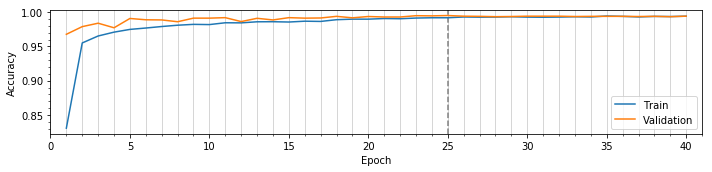

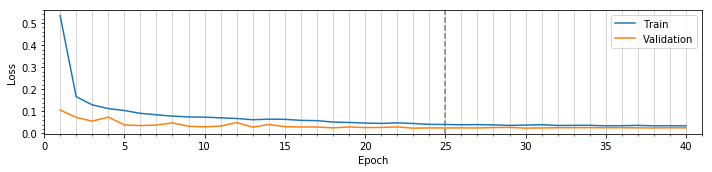

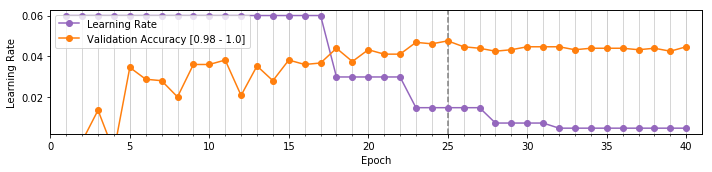

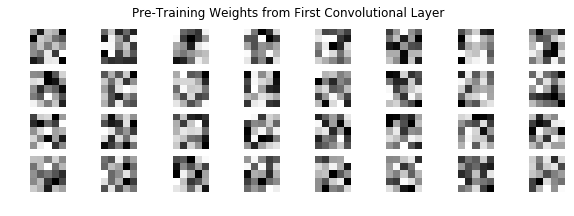

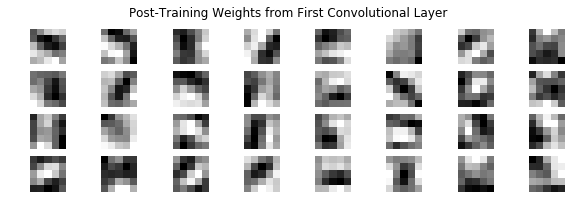

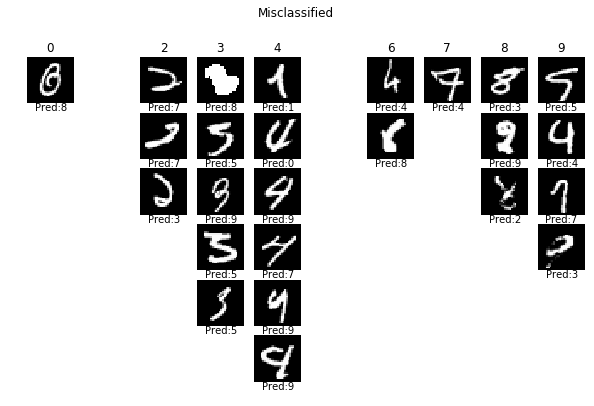

In [19]:
log = pd.read_csv('logs/' + log_filename)
log['epoch'] += 1
evaluate_model(model, X_val, y_val, log, pre_train_weights)

### Save Results

In [20]:
new_result = {}

i = np.argmax(history.history['val_acc'])
new_result['val_acc'] = round(history.history['val_acc'][i], 4)
new_result['val_loss'] = round(history.history['val_loss'][i], 4)
if 'lr' in history.history.keys():
    new_result['lr'] = history.history['lr'][i]
new_result['epoch'] = i + 1

new_result['optimizer'] = history.model.optimizer.__class__.__name__
new_result['optimizer args'] = optimizer_args

new_result['annealer'] = annealer.__class__.__name__
if new_result['annealer'] == 'LearningRateScheduler':
    new_result['annealer'] = annealer.schedule.__doc__
new_result['annealer args'] = annealer_args

new_result['dropout type'] = dropout_type
new_result['dropout rates'] = dropout_rates

new_result['notes'] = notes

new_result['batch size'] = batch_size
new_result['epochs'] = epochs

new_result['log'] = log_filename

new_result['keras'] = keras_version
new_result['tf'] = tf_version

new_result

{'val_acc': 0.995,
 'val_loss': 0.0251,
 'lr': 0.015,
 'epoch': 25,
 'optimizer': 'SGD',
 'optimizer args': '(lr=0.06, momentum=0.96, nesterov=False)',
 'annealer': 'ReduceLROnPlateau',
 'annealer args': "(monitor='val_loss', factor=0.5, patience=4, min_lr=0.001, verbose=1)",
 'dropout type': 'spatial',
 'dropout rates': '(0,0,.3,.5)',
 'notes': '',
 'batch size': 64,
 'epochs': 40,
 'log': '2018-09-03_16-18-55.csv',
 'keras': '2.2.2',
 'tf': '1.10.0'}

In [21]:
results = pd.read_csv('results.csv')
new_results = results.append(new_result, ignore_index=True)
new_results.iloc[[-1]]

,val_acc,val_loss,lr,epoch,optimizer,optimizer args,annealer,annealer args,dropout type,dropout rates,notes,batch size,epochs,log,keras,tf
44,0.995,0.0251,0.015,25,SGD,"(lr=0.06, momentum=0.96, nesterov=False)",ReduceLROnPlateau,"(monitor='val_loss', factor=0.5, patience=4, min_lr=0.001, verbose=1)",spatial,"(0,0,.3,.5)",,64,40,2018-09-03_16-18-55.csv,2.2.2,1.10.0


Overwrite results.csv?

In [22]:
results_filename = 'results.csv'
prompt = "Type y to save updated results to " + results_filename + ": "
overwrite = input(prompt)
if overwrite == 'y':
    new_results.to_csv(results_filename, index=False, float_format='%.4f')
    print(results_filename, "saved")
else:
    print(results_filename, "not saved")

Type y to save updated results to results.csv: y
results.csv saved


### Predict on Test Set

In [28]:
# load test set data
test_data = np.loadtxt('test.csv', dtype=int, delimiter=',', skiprows=1)

In [35]:
# inspect data
print("Raw data shape:", test_data.shape)

# convert pixel values to 2d arrays
test_images = np.reshape(test_data, (28000, 28, 28))
test_images = test_images / 127.5 - 1
test_images = np.expand_dims(test_images, -1)
print("Pixels reshaped shape:", test_images.shape)

Raw data shape: (28000, 784)
Pixels reshaped shape: (28000, 28, 28, 1)


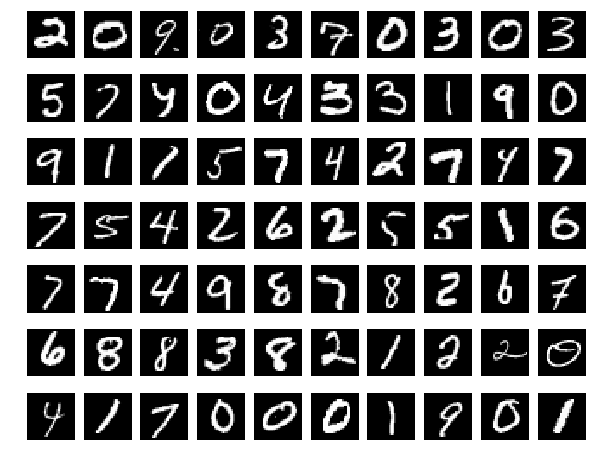

In [61]:
# display random sample of images
plt.rcParams['figure.figsize'] = (10.0, 8.0)
for i in range(70):
    plt.subplot(7, 10, i + 1)
    plt.imshow(test_images[i,:,:,0])
    plt.axis('off')
plt.show()

In [39]:
test_scores = model.predict(test_images)
test_predictions = np.argmax(test_scores, axis=1)

In [64]:
header = 'ImageId,Label'
submission = np.stack((range(1, 28001), test_predictions), axis=1)
print(submission.shape)
np.savetxt('submission.csv', submission, fmt='%i', delimiter=',', header=header, comments='')

(28000, 2)
